## Only Once
This part is to be done only once and for further variations directly use the pre-trained saved file (as the dataset is same)

### Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [2]:
import pandas as pd
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string
import re #regular expression
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import os
import tensorflow as tf


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Read and see the dataset

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Sentiment Analysis - Research Project/Dataset IMDB/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Convert sentiment column:
- `positive = 1`
- `negative = 0`

In [4]:
df['sentiment'][df['sentiment']=='positive'] = 1
df['sentiment'][df['sentiment']=='negative'] = 0
df.shape

(50000, 2)

### Preprocessing
output will be a list of {list of words for each sentence}.

In [5]:
lemmatizer = WordNetLemmatizer()
reviews = list()
stop_words = set(stopwords.words('english'))
lines = df['review'].values.tolist()

for line in lines:
    
    #first we remove the tags as once we split them to words its hard to remove them
    line = re.sub(r'<[^>]+>',' ',line) #remove html tags
    
    tokens = word_tokenize(line)
    tokens = [w.lower() for w in tokens]
    
    #remove punctuaution
    table = str.maketrans('','',string.punctuation)
    stripped = [w.translate(table) for w in tokens]

    #remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]

    #filter out stop words
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words and len(w)>2]
    reviews.append(words)

### Convert to Word2Vec

In [6]:
EMBED_DIM = 100 #each word will become a vector of 100 dimensions
sum_len = 0
max_len = 0
for s in reviews:
    sum_len = sum_len + len(s)
    max_len = max(len(s),max_len)

avg_len = int(sum_len/len(reviews))
print(f'summation - {sum_len}, maximum - {max_len}, average - {avg_len}')

summation - 5767285, maximum - 1383, average - 115


## Variations : Start here and use pre-trained file

In [7]:
embeddings_index = {}
f = open('/content/drive/MyDrive/Sentiment Analysis - Research Project/Dataset IMDB/imdb_embedding_word2vec.txt',encoding='utf-8')
for line in f:
    values = line.split()
    if(len(values)==2): #for skipping the first value of doc size
        continue
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()
print(f'loaded {len(embeddings_index)} word vectors')

loaded 124186 word vectors


In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional, SimpleRNN
from keras.layers.embeddings import Embedding

In [9]:
#vectorize the text samples into 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(reviews)
sequences = tokenizer_obj.texts_to_sequences(reviews)

# fit_on_texts Updates internal vocabulary based on a list of texts. 
# This method creates the vocabulary index based on word frequency.
# So if you give it something like, "The cat sat on the mat." 
# It will create a dictionary s.t. word_index["the"] = 1; 
# word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value.
# 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).

# texts_to_sequences Transforms each text in texts to a sequence of integers.
# So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. 
# Nothing more, nothing less, certainly no magic involved.

#pad sequences
word_index = tokenizer_obj.word_index
print(f'Found {len(word_index)} unique tokens.')


review_pad = pad_sequences(sequences, maxlen=max_len,padding='post')
sentiment = df['sentiment'].values
print(f'Shape of review tensor: {review_pad.shape} and type - {type(review_pad)}')
print(f'Shape of sentiment tensor: {sentiment.shape} and type - {type(sentiment)}')

Found 124186 unique tokens.
Shape of review tensor: (50000, 1383) and type - <class 'numpy.ndarray'>
Shape of sentiment tensor: (50000,) and type - <class 'numpy.ndarray'>


In [10]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBED_DIM))

for word, i in word_index.items():
    # if i>num_words:
    #     continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [11]:
VALIDATION_SPLIT = 0.3 #70-30 train test split
indices = np.arange(review_pad.shape[0])

np.random.shuffle(indices)
review_pad = review_pad[indices]
sentiment = sentiment[indices]
num_validation_samples = int(VALIDATION_SPLIT * review_pad.shape[0])

X_train_pad = review_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = review_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

In [12]:
print(f'Shape of X_train_pad tensor: {X_train_pad.shape}')
print(f'Shape of y_train tensor: {y_train.shape}')
print(f'Shape of X_test_pad tensor: {X_test_pad.shape}')
print(f'Shape of y_test tensor: {y_test.shape}')

Shape of X_train_pad tensor: (35000, 1383)
Shape of y_train tensor: (35000,)
Shape of X_test_pad tensor: (15000, 1383)
Shape of y_test tensor: (15000,)


In [13]:
# data = [[1,2,3],[4,5,6]]
# data_np = np.asarray(data, np.float32)

# data_tf = tf.convert_to_tensor(data_np, np.float32)

y_train = np.asarray(y_train,dtype=np.int)
y_test = np.asarray(y_test,dtype=np.int)
# y_test = tf.convert_to_tensor(y_test,np.float32)
# y_train = tf.convert_to_tensor(y_train,np.float32)


In [16]:
#define model
model = Sequential()
embedding_layer = Embedding(num_words,EMBED_DIM,weights=[embedding_matrix],input_length=max_len,trainable=False)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(64,dropout=0.2,return_sequences=True)))
model.add(SimpleRNN(64))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1383, 100)         12418700  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1383, 128)         84480     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 12,515,597
Trainable params: 96,897
Non-trainable params: 12,418,700
_________________________________________________________________


In [17]:
print('Train....')
history = model.fit(X_train_pad, y_train, batch_size=128, epochs=10, validation_data=(X_test_pad,y_test),verbose=1)

Train....
Epoch 1/10
274/274 [==============================] - 382s 1s/step - loss: 0.6943 - accuracy: 0.4981 - val_loss: 0.6931 - val_accuracy: 0.5012
Epoch 2/10
274/274 [==============================] - 376s 1s/step - loss: 0.6945 - accuracy: 0.5023 - val_loss: 0.6959 - val_accuracy: 0.5052
Epoch 3/10
274/274 [==============================] - 377s 1s/step - loss: 0.6965 - accuracy: 0.5004 - val_loss: 0.6969 - val_accuracy: 0.4969
Epoch 4/10
274/274 [==============================] - 376s 1s/step - loss: 0.6942 - accuracy: 0.5017 - val_loss: 0.6979 - val_accuracy: 0.4988
Epoch 5/10
274/274 [==============================] - 376s 1s/step - loss: 0.6941 - accuracy: 0.4993 - val_loss: 0.6952 - val_accuracy: 0.4988
Epoch 6/10
274/274 [==============================] - 373s 1s/step - loss: 0.6938 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 7/10
274/274 [==============================] - 372s 1s/step - loss: 0.6936 - accuracy: 0.4975 - val_loss: 0.6932 - val_accura

In [18]:
def plotLearningCurve(history,epochs):
    import matplotlib.pyplot as plt

    epoch_range = range(1,epochs+1)
    plt.plot(epoch_range,history['accuracy'])
    plt.plot(epoch_range,history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train','Val'])
    plt.show()

    plt.plot(epoch_range,history['loss'])
    plt.plot(epoch_range,history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train','Val'])
    plt.show()

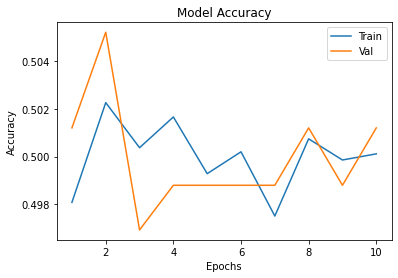

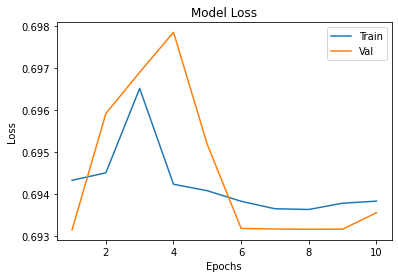

In [19]:
plotLearningCurve(history.history,len(history.epoch))